<a href="https://colab.research.google.com/github/deepkick/pytorch_handbook/blob/master/chapter4/section4_2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# #colabを使う方はこちらを使用ください。
# !pip install torch==0.4.1
# !pip install torchvision==0.2.1
# !pip install numpy==1.14.6
# !pip install matplotlib==2.1.2
# !pip install pillow==5.0.0
# !pip install opencv-python==3.4.3.18
# !pip install torchtext==0.3.1

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import time
import os

In [3]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


# 独自データセットを畳み込みニューラルネットで画像分類

## データの読み込み

In [4]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2020-04-09 10:35:53--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.222.141.74, 52.222.141.39, 52.222.141.32, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.222.141.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  20.1MB/s    in 2.2s    

2020-04-09 10:35:55 (20.1 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_dat

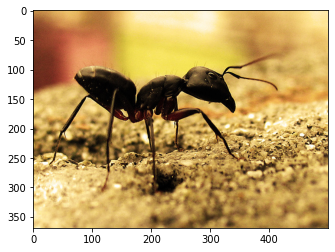

In [5]:
# OpenCVで画像を読み込む例

import cv2
#画像の読み込み
img = cv2.imread('./hymenoptera_data/train/ants/649026570_e58656104b.jpg')
#画像のチャンネルをbgrからrgbに変換
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#画像を表示
plt.imshow(img)
plt.show()

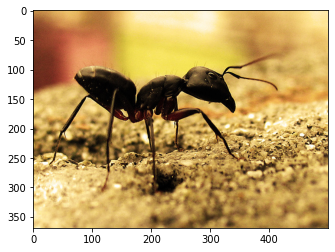

In [6]:
# Pillowで画像を読み込む例

from PIL import Image
#画像の読み込み
image = "./hymenoptera_data/train/ants/649026570_e58656104b.jpg"
with open(image, 'rb') as f:
    image = Image.open(f)
    image = image.convert('RGB')
#画像を表示
plt.imshow(img)
plt.show()

pyTorchのtransforms,Datasets,Dataloaderの説明と自作Datasetの作成と使用  
https://qiita.com/mathlive/items/2a512831878b8018db02  

Transforms on PIL Image  
https://pytorch.org/docs/stable/torchvision/transforms.html  

https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor  
CLASS torchvision.transforms.ToTensor  
Convert a PIL Image or numpy.ndarray to tensor.

https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomResizedCrop  
CLASS torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)  
Crop the given PIL Image to random size and aspect ratio.  

https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip  
CLASStorchvision.transforms.RandomHorizontalFlip(p=0.5)  
Horizontally flip the given PIL Image randomly with a given probability.  

https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize  
CLASStorchvision.transforms.Normalize(mean, std, inplace=False)  
Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]  

https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize  
CLASStorchvision.transforms.Resize(size, interpolation=2)  
Resize the input PIL Image to the given size.  

https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.CenterCrop  
CLASStorchvision.transforms.CenterCrop(size)  
Crops the given PIL Image at the center.  



In [0]:
#画像の前処理を定義
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}
#正規化をしない前処理
to_tensor_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

In [8]:
data_transforms["train"]

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [9]:
data_transforms["val"]

Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [0]:
# PyTorch用の画像データセットを作成する
# torch.utils.data.Datasetを継承してクラスを定義する
# __init__ で読み込むファイルパスの一覧を用意する
# __getitem__ でパスから取り出して前処理し、画像と正解ラベルのペアを返す処理
# __len__ には全データ数を入れる

root = 'hymenoptera_data'
class CustomDataset(torch.utils.data.Dataset):  
    classes = ['ant', 'bee']
  
    def __init__(self, root, transform=None, train=True):
        # 指定する場合は前処理クラスを受け取ります。
        self.transform = transform
        # 画像とラベルの一覧を保持するリスト
        self.images = []
        self.labels = []
        # ルートフォルダーパス
        root = "hymenoptera_data"
        # 訓練の場合と検証の場合でフォルダわけ
        # 画像を読み込むファイルパスを取得します。
        if train == True:
            root_ants_path = os.path.join(root, 'train', 'ants')
            root_bees_path = os.path.join(root, 'train', 'bees')
        else:
            root_ants_path = os.path.join(root, 'val', 'ants')
            root_bees_path = os.path.join(root, 'val', 'bees')
        # アリの画像一覧を取得します。
        ant_images = os.listdir(root_ants_path)
        # ここではアリをラベル０に指定します。
        ant_labels = [0] * len(ant_images)
        # ハチの画像一覧を取得します。
        bee_images = os.listdir(root_bees_path)
        # ここではハチをラベル１に指定します。
        bee_labels = [1] * len(bee_images)
        # 1個のリストにします。
        for image, label in zip(ant_images, ant_labels):
            self.images.append(os.path.join(root_ants_path, image))
            self.labels.append(label)
        for image, label in zip(bee_images, bee_labels):
            self.images.append(os.path.join(root_bees_path, image))
            self.labels.append(label)
        
    def __getitem__(self, index):
        # インデックスを元に画像のファイルパスとラベルを取得します。
        image = self.images[index]
        label = self.labels[index]
        # 画像ファイルパスから画像を読み込みます。
        with open(image, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')
        # 前処理がある場合は前処理をいれます。
        if self.transform is not None:
            image = self.transform(image)
        # 画像とラベルのペアを返却します。
        return image, label
        
    def __len__(self):
        # ここにはデータ数を指定します。
        return len(self.images)


[1 0 0 0 0]


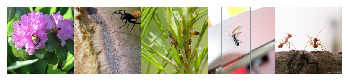

In [12]:
# カスタムデータセットからデータを読み込んで画像を表示
# torch.vision.utils.make_gridを使用すると、画像を並べて表示することができる
# 訓練データのプロット
custom_dataset = CustomDataset(root, to_tensor_transforms, train=True)
custom_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=5, 
                                           shuffle=True)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

for i, (images, labels) in enumerate(custom_loader):
    print(labels.numpy())
    show(torchvision.utils.make_grid(images, padding=1))
    plt.axis('off')
    
    break

[0 1 0 0 0]


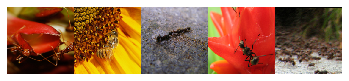

In [13]:
# テストデータのプロット
custom_dataset = CustomDataset(root, to_tensor_transforms)
custom_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=5, 
                                           shuffle=True)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

for i, (images, labels) in enumerate(custom_loader):
    print(labels.numpy())
    show(torchvision.utils.make_grid(images, padding=1))
    plt.axis('off')
    
    break

In [16]:
# 定義したDatasetとDataLoaderを使います。
custom_train_dataset = CustomDataset(root, data_transforms["train"], train=True)
train_loader = torch.utils.data.DataLoader(dataset=custom_train_dataset,
                                           batch_size=5, 
                                           shuffle=True)
custom_test_dataset = CustomDataset(root, data_transforms["val"])
test_loader = torch.utils.data.DataLoader(dataset=custom_test_dataset,
                                           batch_size=5, 
                                           shuffle=False)

for i, (images, labels) in enumerate(train_loader):
    print(images.size())
    print(images[0].size())    
    print(labels[0].item())
    #ここに訓練などの処理をきます。
    break

print(train_loader)

torch.Size([5, 3, 224, 224])
torch.Size([3, 224, 224])
1


## ネットワークの定義

In [0]:
# AlexNetをアリとハチの２クラス分類用に変更
#クラス数変更
num_classes = 2

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), #padding=5から2に変更。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        #全結合部分の変更。
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

## 学習

In [19]:
#エラーになる例
num_epochs = 50

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

RuntimeError: ignored

In [20]:
#全結合の次元を計算
size_check = torch.FloatTensor(10, 3, 224, 224)
features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
#バッチサイズ10, 6×6のフィルターが256枚
#10バッチは残して、6×6×256を１次元に落とす=>6×6×256=9216
print(features(size_check).size())
#バッチ１０の値を軸にして残りの次元を１次元へ落とした場合のTensorの形状をチェックすると9216。
print(features(size_check).view(size_check.size(0), -1).size())
#fc_sizeを全結合の形状として保持しておく
fc_size = features(size_check).view(size_check.size(0), -1).size()[1]
print(fc_size)

torch.Size([10, 256, 6, 6])
torch.Size([10, 9216])
9216


In [0]:
num_classes = 2

class AlexNet(nn.Module):
    #fc_sizeを引き渡す
    def __init__(self, num_classes, fc_size):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        #fc_sizeで計算した形状を指定
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(fc_size, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes, fc_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [22]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [23]:
num_epochs = 100

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/100], Loss: 0.1391, val_loss: 0.1386, val_acc: 0.5306
Epoch [2/100], Loss: 0.1393, val_loss: 0.1385, val_acc: 0.5061
Epoch [3/100], Loss: 0.1391, val_loss: 0.1385, val_acc: 0.5061
Epoch [4/100], Loss: 0.1394, val_loss: 0.1378, val_acc: 0.6041
Epoch [5/100], Loss: 0.1393, val_loss: 0.1394, val_acc: 0.5061
Epoch [6/100], Loss: 0.1387, val_loss: 0.1379, val_acc: 0.4939
Epoch [7/100], Loss: 0.1385, val_loss: 0.1362, val_acc: 0.5429
Epoch [8/100], Loss: 0.1392, val_loss: 0.1357, val_acc: 0.5347
Epoch [9/100], Loss: 0.1375, val_loss: 0.1462, val_acc: 0.5061
Epoch [10/100], Loss: 0.1422, val_loss: 0.1388, val_acc: 0.4939
Epoch [11/100], Loss: 0.1390, val_loss: 0.1382, val_acc: 0.5061
Epoch [12/100], Loss: 0.1391, val_loss: 0.1391, val_acc: 0.4939
Epoch [13/100], Loss: 0.1396, val_loss: 0.1388, val_acc: 0.5061
Epoch [14/100], Loss: 0.1385, val_loss: 0.1375, val_acc: 0.5061
Epoch [15/100], Loss: 0.1389, val_loss: 0.1389, val_acc: 0.4939
Epoch [16/100], Loss: 0.1366, val_loss: 0.1320, v

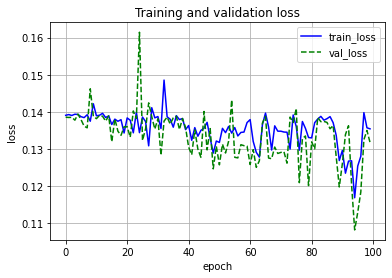

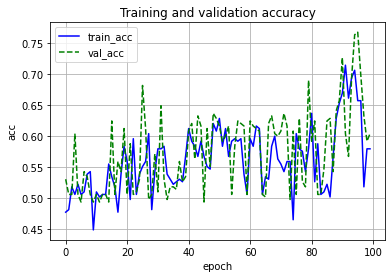

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## ImageFolderを使用する

In [0]:
#画像とラベルを読み込む
data_dir = 'hymenoptera_data'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                                                  data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                                                data_transforms['val'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5,
                                             shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5,
                                             shuffle=False, num_workers=4)

In [26]:
for train in train_loader:
    print(train[0].shape)
    print(train[0].dtype)
    break

torch.Size([5, 3, 224, 224])
torch.float32
